# 국립공원 변화탐지
-  Sentinel-1호 위성 데이터를 활용해 지표면 변화를 탐지하고 더 나아가 관심 지역의 식생 지수에 대한 시계열 분석과 timelapse 생성

### Import Library

In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
import folium
import pandas as pd
%matplotlib inline

#### Google Earth API 인증

In [2]:
import os

os.environ['EARTHENGINE_API_KEY'] = 'Your API key'

In [ ]:
# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize()

In [24]:
# Folium 지도에 레이어 추가 함수
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds Earth Engine layers to a folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name = name,
        overlay = True,
        control = True).add_to(self)

# folium 지도 객체에 Earth Engine 레이어 추가 메서드를 연결
folium.Map.add_ee_layer = add_ee_layer

### 관심지역(AOI) 설정

In [ ]:
# 국립공원 리스트
national_parks = [
    "Jirisan", "Gyeongju", "Gyeryongsan", "Hallyeohaesang", "Seoraksan",
    "Songnisan", "Taeanhaean", "Dadohaehaesang", "Chiaksan", "Woraksan",
    "Bukhansan", "Sobaeksan", "Naejangsan", "Wolchulsan", "Gayasan",
    "Byeonsanbando", "Deogyusan", "Mudeungsan", "Odaesan", "Taebaeksan",
    "Juwangsan", "Hallasan", "Palgongsan"
]

In [8]:
# 관심 국립공원 영역 추출
park_aoi = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
        .filter(ee.Filter.eq("NAME", "Bukhansan")) \
        .geometry()

# 관심 국립공원 경계 추출
park_boundary = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
        .filter(ee.Filter.eq("NAME", "Bukhansan"))

# # 지리산과 설악산의 경우 WDPAID 사용
# aoi = ee.FeatureCollection("WCMC/WDPA/current/polygons") \
#         .filter(ee.Filter.eq("WDPAID", 767)) \
#         .geometry()

### 데이터 수집

In [10]:
# 위성 이미지 컬렉션을 필터링하여 가져오기
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
           .filterBounds(park_aoi)
           .filterDate(ee.Date('2014-01-01'),ee.Date('2023-12-31'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) 
           .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
           .filter(ee.Filter.eq('instrumentMode', 'IW'))
           .filter(ee.Filter.eq('platform_number', 'A'))
           .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
           .sort('date'))

In [ ]:
# 이미지 컬렉션에서 AOI와의 겹침 비율을 계산하는 함수
def filter_by_coverage(image):
    # 이미지와 AOI의 겹치는 영역을 계산
    overlap_area = image.geometry().intersection(aoi, ee.ErrorMargin(1)).area()
    # AOI의 전체 영역을 계산
    aoi_area = park_aoi.area()
    # 겹침 비율을 계산
    coverage_ratio = overlap_area.divide(aoi_area)
    # 겹침 비율이 임계값 이상인지 여부를 판단하는 변수를 이미지에 추가
    return image.set('coverage_ratio', coverage_ratio)

# 임계값 설정 (예: 0.9는 AOI의 90% 이상 커버해야 함을 의미)
COVERAGE_THRESHOLD = 0.8

# 이미지 컬렉션에 filter_by_coverage 함수를 적용
im_coll_with_coverage = im_coll.map(filter_by_coverage)

# 임계값 미만으로 겹치는 이미지를 제외
im_coll = im_coll_with_coverage.filter(ee.Filter.greaterThanOrEquals('coverage_ratio', COVERAGE_THRESHOLD))

▲ 불러온 이미지 데이터 확인 결과 AOI 전체를 커버하지 못하는 이미지 발견 

-> 임계값을 통해 겹치는 비율이 적을 경우 해당 이미지를 이미지 컬렉션에서 제거

In [11]:
im_coll

In [12]:
# 타임스태프 목록 생성
timestamplist = (im_coll.aggregate_array('date')
                 .map(lambda d: ee.String('T').cat(ee.String(d)))
                 .getInfo())
timestamplist

['T20150518',
 'T20150518',
 'T20160711',
 'T20170224',
 'T20170308',
 'T20170320',
 'T20170401',
 'T20170413',
 'T20170425',
 'T20170507',
 'T20170519',
 'T20170531',
 'T20170612',
 'T20170624',
 'T20170706',
 'T20170718',
 'T20170730',
 'T20170811',
 'T20170823',
 'T20170904',
 'T20170916',
 'T20170928',
 'T20171010',
 'T20171022',
 'T20171103',
 'T20171209',
 'T20171221',
 'T20180102',
 'T20180114',
 'T20180207',
 'T20180619',
 'T20180701',
 'T20180713',
 'T20180725',
 'T20180806',
 'T20180830',
 'T20180911',
 'T20180923',
 'T20181005',
 'T20181017',
 'T20181029',
 'T20181110',
 'T20181122',
 'T20181204',
 'T20181216',
 'T20181228',
 'T20190109',
 'T20190121',
 'T20190202',
 'T20190214',
 'T20190226',
 'T20190310',
 'T20190322',
 'T20190403',
 'T20190415',
 'T20190427',
 'T20190509',
 'T20190521',
 'T20190602',
 'T20190614',
 'T20190813',
 'T20190825',
 'T20190906',
 'T20190918',
 'T20190930',
 'T20191012',
 'T20191024',
 'T20191105',
 'T20191117',
 'T20191129',
 'T20191211',
 'T201

In [15]:
# 이미지 리스트를 관심지역으로 자르는 함수
def clip_img(img):
    """Clips a list of images."""
    return ee.Image(img).clip(park_aoi)

# 이미지 컬렉션을 리스트로 변환하고 각 이미지를 관심 지역에 맞게 자르기
im_list = im_coll.toList(im_coll.size())
im_list = ee.List(im_list.map(clip_img))

# im_list.length().getInfo()

▲ 가져온 이미지는 관심영역 이외에도 다른 부분까지도 찍힌 이미지로서 clip 함수를 통해 이미지를 관심영역에 맞게 잘라줌

In [14]:
def selectvv(current):
    return ee.Image(current).select('VV')

# clip 함수 적용전 임의의 원본 이미지
original_image = ee.Image(im_coll.toList(im_coll.size()).get(12))

original_image_VV = original_image.select('VV')

In [16]:
# Clip 함수 적용 후 잘린 이미지
vv_list = im_list.map(selectvv)
clip_image = vv_list.get(12)

In [20]:
# 지도 시각화
location = park_aoi.centroid().coordinates().getInfo()[::-1]

#지도 생성 
mp = geemap.Map(location = location, zoom_start=11)

image1 = (ee.Image(original_image_VV).log10().multiply(10))
image2 = (ee.Image(clip_image).log10().multiply(10))

mp.add_ee_layer(image1, {'min': -20,'max': 0}, 'original_image')
mp.add_ee_layer(image2, {'min': -20,'max': 0}, 'clip_image')
mp.add_ee_layer(park_boundary, {'color': 'red'}, 'park_boundary')

mp

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [21]:
from collections import Counter
# 중복된 날짜를 찾기 위한 카운터 생성
counter = Counter(timestamplist)

# 중복된 날짜와 그 빈도수를 찾기
duplicates = {date: count for date, count in counter.items() if count > 1}

duplicates

{'T20150518': 2}

▲ 중복된 날짜의 이미지 확인 결과 관심영역을 서로 겹치지 않은 서로 다른 AOI의 영역을 찍은 것을 확인

- ee에서 제공하는 mosaic 함수를 통해 병합 시도 
- 병합은 성공했으나, 이미지 내에 VV, VH 밴드값을 불러오지 못하는 문제 발생 
    
    -> 추후 해결 예정

## 변화탐지 알고리즘 

1. 수집 이미지의 VV, VH 밴드의 반사율에 대한 값을 공분산 행렬로 추출
2. 이미지 행렬 값을 누적분포 히스토그램으로 나타내고 카이제곱 분포와 유사한지 확인
     - 카이제곱 분포와 유사하다면, 오차(=변화)가 우연히 발생한 것인지 그렇지 않은지를 판별 가능
3. 유사하다는 가정 하에, 유의미한 변화인지를 검정하기 위해 우도비 검정 통계량 값으로 바꾼 다음 p-value 계산
4. 검정 방법으로 Sequential Omnibus test 수행
    - Omnibus test 
        - 시계열 데이터 내 각 픽셀에서 유의미한 변화가 일어났는지를 검증
        - 어느 시간대의 이미지에 변화가 있었는지를 확인하기 위해 sequential 로 진행
        
        ex) H0 : α1 = α2 = α3
            H1 : α1 = α2 != α3 
5. 어느 방향(반사율 증가, 감소)로 변하였는지 구분하기 위해 The Loewner order 진행

In [22]:
# 누적분포함수를 계산
def chi2cdf(chi2, df):
    """Calculates Chi square cumulative distribution function for
       df degrees of freedom using the built-in incomplete gamma
       function gammainc().
    """
    return ee.Image(chi2.divide(2)).gammainc(ee.Number(df).divide(2))

▲ 이미지에서 추출한 공분산 행렬의 누적 분포함수 계산

-> 분모 모양을 확인하기 위해

In [23]:
# 공분산 행렬식 계산
def det(im):
    """Calculates determinant of 2x2 diagonal covariance matrix."""
    return im.expression('b(0)*b(1)')

▲ 각 이미지의 공분산 행렬식 추출

### Omnibus 검정

In [25]:
def omnibus(im_list, m = 4.4):
    """Calculates the omnibus test statistic, monovariate case."""
    def log(current):
        return ee.Image(current).log()

    im_list = ee.List(im_list)
    k = im_list.length()
    klogk = k.multiply(k.log())
    klogk = ee.Image.constant(klogk)
    sumlogs = ee.ImageCollection(im_list.map(log)).reduce(ee.Reducer.sum())
    logsum = ee.ImageCollection(im_list).reduce(ee.Reducer.sum()).log()
    return klogk.add(sumlogs).subtract(logsum.multiply(k)).multiply(-2*m)

In [26]:
# im_list 내 첫 j개 이미지의 합의 행렬식 로그를 반환하는 함수
def log_det_sum(im_list, j):
    """Returns log of determinant of the sum of the first j images in im_list."""
    im_ist = ee.List(im_list)
    sumj = ee.ImageCollection(im_list.slice(0, j)).reduce(ee.Reducer.sum())
    return ee.Image(det(sumj)).log()

# im_list의 j번째 이미지의 행렬식 로그를 반환하는 함수
def log_det(im_list, j):
    """Returns log of the determinant of the jth image in im_list."""
    im = ee.Image(ee.List(im_list).get(j.subtract(1)))
    return ee.Image(det(im)).log()

#  im_list에 대해 -2logRj를 계산하고 P값과 -2logRj를 반환하는 함수
def pval(im_list, j, m=4.4):
    """Calculates -2logRj for im_list and returns P value and -2logRj."""
    im_list = ee.List(im_list)
    j = ee.Number(j)
    m2logRj = (log_det_sum(im_list, j.subtract(1))
               .multiply(j.subtract(1))
               .add(log_det(im_list, j))
               .add(ee.Number(2).multiply(j).multiply(j.log()))
               .subtract(ee.Number(2).multiply(j.subtract(1))
               .multiply(j.subtract(1).log()))
               .subtract(log_det_sum(im_list,j).multiply(j))
               .multiply(-2).multiply(m))
    pv = ee.Image.constant(1).subtract(chi2cdf(m2logRj, 2))
    return (pv, m2logRj)

# 이미지 리스트에 대한 P값 배열을 사전 계산하는 함수.
def p_values(im_list):
    """Pre-calculates the P-value array for a list of images."""
    im_list = ee.List(im_list)
    k = im_list.length()
    #  k와 j의 조합에 대해 pval 계산을 정리하는 함수
    def ells_map(ell):
        """Arranges calculation of pval for combinations of k and j."""
        ell = ee.Number(ell)
        # k-l+1부터 k까지의 시리즈를 슬라이스 (이미지 인덱스는 0부터 시작)
        im_list_ell = im_list.slice(k.subtract(ell), k)
        #  k와 j의 조합에 대해 pval 계산을 적용하는 함수
        def js_map(j):
            """Applies pval calculation for combinations of k and j."""
            j = ee.Number(j)
            pv1, m2logRj1 = pval(im_list_ell, j)
            return ee.Feature(None, {'pv': pv1, 'm2logRj': m2logRj1})
        
        # j=2,3,...,l에 대해 매핑
        js = ee.List.sequence(2, ell)
        pv_m2logRj = ee.FeatureCollection(js.map(js_map))

        # m2logRj 이미지의 컬렉션에서 m2logQl 계산
        m2logQl = ee.ImageCollection(pv_m2logRj.aggregate_array('m2logRj')).sum()
        pvQl = ee.Image.constant(1).subtract(chi2cdf(m2logQl, ell.subtract(1).multiply(2)))
        pvs = ee.List(pv_m2logRj.aggregate_array('pv')).add(pvQl)
        return pvs

    # l = k,...,2에 대해 매핑
    ells = ee.List.sequence(k, 2, -1)
    pv_arr = ells.map(ells_map)

    # P 값 배열을 반환 (ell = k,...,2, j = 2,...,l)
    return pv_arr

In [27]:
# 변화지도를 계산하는 함수; pv_arr의 j 인덱스에 대해 반복
# current: 현재 P값
# prev: 이전 단계의 결과
def filter_j(current, prev):
    """Calculates change maps; iterates over j indices of pv_arr."""
    pv = ee.Image(current)
    prev = ee.Dictionary(prev)
    pvQ = ee.Image(prev.get('pvQ'))
    i = ee.Number(prev.get('i'))
    cmap = ee.Image(prev.get('cmap'))
    smap = ee.Image(prev.get('smap'))
    fmap = ee.Image(prev.get('fmap'))
    bmap = ee.Image(prev.get('bmap'))
    alpha = ee.Image(prev.get('alpha'))
    j = ee.Number(prev.get('j'))
    cmapj = cmap.multiply(0).add(i.add(j).subtract(1))
    # Check      Rj?            Ql?                  Row i?
    tst = pv.lt(alpha).And(pvQ.lt(alpha)).And(cmap.eq(i.subtract(1)))
    # Then update cmap...
    cmap = cmap.where(tst, cmapj)
    # ...and fmap...
    fmap = fmap.where(tst, fmap.add(1))
    # ...and smap only if in first row.
    smap = ee.Algorithms.If(i.eq(1), smap.where(tst, cmapj), smap)
    # bmap 밴드 생성 및 bmap 이미지에 추가
    idx = i.add(j).subtract(2)
    tmp = bmap.select(idx)
    bname = bmap.bandNames().get(idx)
    tmp = tmp.where(tst, 1)
    tmp = tmp.rename([bname])
    bmap = bmap.addBands(tmp, [bname], True)
    return ee.Dictionary({'i': i, 'j': j.add(1), 'alpha': alpha, 'pvQ': pvQ,
                          'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap':bmap})

# 변화지도 계산을 준비하는 함수; pv_arr의 행 인덱스에 대해 반복.
def filter_i(current, prev):
    """Arranges calculation of change maps; iterates over row-indices of pv_arr."""
    current = ee.List(current)
    pvs = current.slice(0, -1 )
    pvQ = ee.Image(current.get(-1))
    prev = ee.Dictionary(prev)
    i = ee.Number(prev.get('i'))
    alpha = ee.Image(prev.get('alpha'))
    median = prev.get('median')
    # 필요한 경우 Ql P값 필터링
    pvQ = ee.Algorithms.If(median, pvQ.focalMedian(2.5), pvQ)
    cmap = prev.get('cmap')
    smap = prev.get('smap')
    fmap = prev.get('fmap')
    bmap = prev.get('bmap')
    first = ee.Dictionary({'i': i, 'j': 1, 'alpha': alpha ,'pvQ': pvQ,
                           'cmap': cmap, 'smap': smap, 'fmap': fmap, 'bmap': bmap})
    result = ee.Dictionary(ee.List(pvs).iterate(filter_j, first))
    return ee.Dictionary({'i': i.add(1), 'alpha': alpha, 'median': median,
                          'cmap': result.get('cmap'), 'smap': result.get('smap'),
                          'fmap': result.get('fmap'), 'bmap': result.get('bmap')})

In [28]:
# 변화 방향을 계산하는 반복 함수
def dmap_iter(current, prev):
    """변화 방향에 따라 값 재분류"""
    prev = ee.Dictionary(prev)
    j = ee.Number(prev.get('j'))
    image = ee.Image(current)
    avimg = ee.Image(prev.get('avimg'))
    diff = image.subtract(avimg)
    # Get positive/negative definiteness.
    posd = ee.Image(diff.select(0).gt(0).And(det(diff).gt(0)))
    negd = ee.Image(diff.select(0).lt(0).And(det(diff).gt(0)))
    bmap = ee.Image(prev.get('bmap'))
    bmapj = bmap.select(j)
    dmap = ee.Image.constant(ee.List.sequence(1, 3))
    bmapj = bmapj.where(bmapj, dmap.select(2))
    bmapj = bmapj.where(bmapj.And(posd), dmap.select(0))
    bmapj = bmapj.where(bmapj.And(negd), dmap.select(1))
    bmap = bmap.addBands(bmapj, overwrite=True)
    # Update avimg with provisional means.
    i = ee.Image(prev.get('i')).add(1)
    avimg = avimg.add(image.subtract(avimg).divide(i))
    # 변화가 발생한 경우 avimg를 현재 이미지로 설정하고 i를 1로 재설정
    avimg = avimg.where(bmapj, image)
    i = i.where(bmapj, 1)
    return ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j.add(1), 'i': i})

In [29]:
def change_maps(im_list, median=False, alpha=0.01):
    """Calculates thematic change maps."""
    k = im_list.length()
    # Pre-calculate the P value array.
    pv_arr = ee.List(p_values(im_list))
    # Filter P values for change maps.
    cmap = ee.Image(im_list.get(0)).select(0).multiply(0)
    bmap = ee.Image.constant(ee.List.repeat(0,k.subtract(1))).add(cmap)
    alpha = ee.Image.constant(alpha)
    first = ee.Dictionary({'i': 1, 'alpha': alpha, 'median': median,
                           'cmap': cmap, 'smap': cmap, 'fmap': cmap, 'bmap': bmap})
    result = ee.Dictionary(pv_arr.iterate(filter_i, first))
    # Post-process bmap for change direction.
    bmap =  ee.Image(result.get('bmap'))
    avimg = ee.Image(im_list.get(0))
    j = ee.Number(0)
    i = ee.Image.constant(1)
    first = ee.Dictionary({'avimg': avimg, 'bmap': bmap, 'j': j, 'i': i})
    dmap = ee.Dictionary(im_list.slice(1).iterate(dmap_iter, first)).get('bmap')
    return ee.Dictionary(result.set('bmap', dmap))

In [30]:
# folium 지도 생성
location = park_aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=13)

In [31]:
# 변화 방향을 포함한 테마별 변화지도 계산
result = ee.Dictionary(change_maps(im_list, median=True, alpha=0.01))

# Extract the change maps and export to assets.
cmap = ee.Image(result.get('cmap'))
smap = ee.Image(result.get('smap'))
fmap = ee.Image(result.get('fmap'))
bmap = ee.Image(result.get('bmap'))
cmaps = ee.Image.cat(cmap, smap, fmap, bmap).rename(['cmap', 'smap', 'fmap']+timestamplist[1:])

In [ ]:
# 변화가 있는 영역만 마스킹
cmaps = cmaps.updateMask(cmaps.gt(0))

location = park_aoi.centroid().coordinates().getInfo()[::-1]
palette = ['black', 'red', 'cyan', 'yellow']
# mp = folium.Map(location=location, zoom_start=13)

# cmaps 이미지에서 모든 밴드 이름을 가져옴
band_names = cmaps.bandNames().getInfo()

# folium 지도에 각 날짜에 해당하는 레이어를 추가하는 반복문
for band_name in band_names:
    # T로 시작하는 밴드 이름만 필터링 (날짜에 해당하는 밴드)
    if band_name.startswith('T'):
        mp.add_ee_layer(cmaps.select(band_name), {'min': 0, 'max': 3, 'palette': palette}, band_name)

# 지도에 레이어 컨트롤 추가
mp.add_child(folium.LayerControl())

#### V-world 레이어 추가

In [ ]:
# V-World 타일 서비스 URL (API 키 포함)
vworld_satellite_url = "http://api.vworld.kr/req/wmts/1.0.0/{api_key}/Satellite/{z}/{y}/{x}.jpeg"
vworld_hybrid_url = "http://api.vworld.kr/req/wmts/1.0.0/{api_key}/Hybrid/{z}/{y}/{x}.png"

# API 키를 여기에 입력하세요
api_key = "your API key"
# V-World 타일 레이어 추가
folium.TileLayer(tiles=vworld_satellite_url.replace("{api_key}", api_key),
                 attr='V-World Satellite',
                 name='V-World Satellite', overlay = True).add_to(mp)

folium.TileLayer(tiles=vworld_hybrid_url.replace("{api_key}", api_key),
                 attr='V-World Hybrid',
                 name='V-World Hybrid', overlay = True).add_to(mp)

- 변화 지도는 Sentinel-1 위성 이미지에서 추출된 지표면 반사율에 대한 변화를 나타낸 지도
    - 시간에 따른 자연한 변화가 아닌 유의미한 변화를 도출
        
        ex) 산림변화(벌채, 산불, 산사태) / 수계변화 (호수, 강의 수위변화나 유실) / 건설 활동
    - 양(+)의 변화는 빨간색, 음(-)의 변화는 파란색, 변화는 있으나 변화라고 확실할 수 없는 변화를 노란색으로 나타냄

- 특정 지역에서 연속적으로 변화가 감지됐다면, 해당 지역의 잦은 지형 변화를 의미하기에 눈 여겨볼 필요가 있는 집중관리지역이라고 판단
- 해당 이미지만으로는 변화의 정확한 원인을 파악하기 어렵기에 현장 조사, 또는 과거의 기록이나 보고서 등을 통해 변화의 원인을 추측해 볼 수 있을 것

## 시계열 분석 - 식생지수 (RVI)
- RVI = 4VH / (VV + VH)

In [34]:
from prophet import Prophet

In [35]:
# 식생지수 계산
def calculate_vegetation_index(image):
    vv = image.select('VV')
    vh = image.select('VH')
    vegetation_index = vh.multiply(4).divide(vv.add(vh))
    return image.addBands(vegetation_index.rename('RVI'))

# 식생지수를 포함한 컬렉션 생성
vi_collection = im_coll.map(calculate_vegetation_index)

In [36]:
# 함수: 이미지 컬렉션에서 식생지수 통계를 추출
def extract_statistics(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=park_aoi,
        scale=30
    ).get('RVI')
    return image.set('date', image.date().format()).set('mean_rvi', mean_dict)

# 식생지수 통계를 포함한 컬렉션
stats_collection = vi_collection.map(extract_statistics)

# Earth Engine 객체를 리스트로 변환
stats_list = stats_collection.reduceColumns(
    ee.Reducer.toList(2), ['date', 'mean_rvi']
).values().get(0).getInfo()

# 리스트를 데이터프레임으로 변환
df = pd.DataFrame(stats_list, columns=['Date', 'Mean_RVI'])
df['Date'] = pd.to_datetime(df['Date'])

# 데이터프레임 출력
print(df.head())

                 Date  Mean_RVI
0 2015-05-18 09:31:17  0.789587
1 2015-05-18 09:31:42  0.768217
2 2016-07-11 09:31:33  0.893410
3 2017-02-24 09:31:46  0.913637
4 2017-03-08 09:31:46  0.925906


#### 시계열 분석 알고리즘 - Prophet

18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:37 - cmdstanpy - INFO - Chain [1] done processing


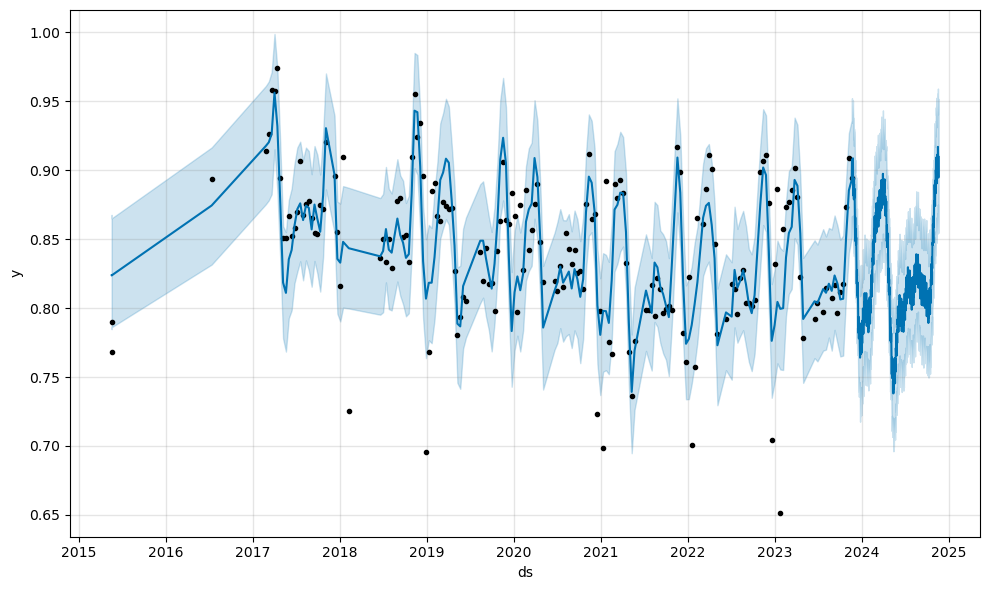

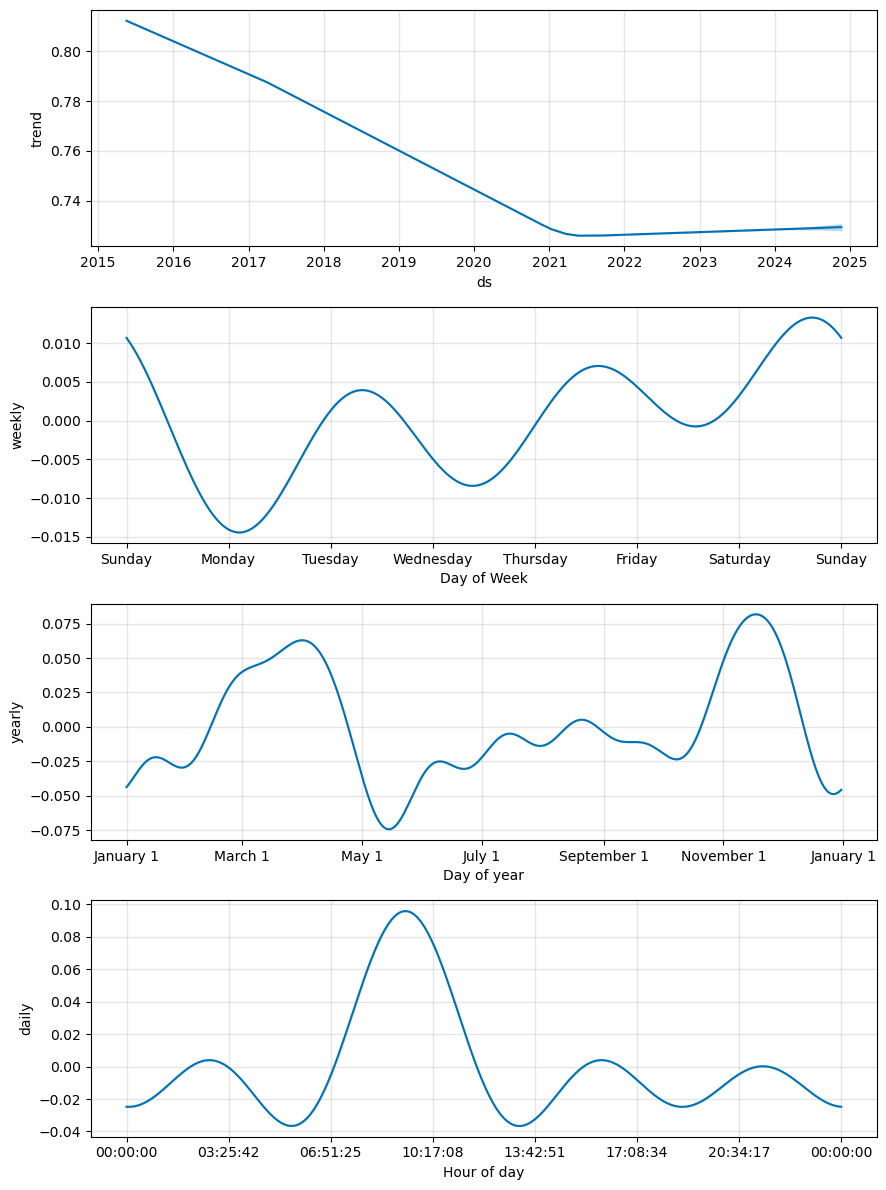

In [37]:
# 열 이름을 Prophet이 요구하는 형식으로 변경합니다.
df.rename(columns={'Date': 'ds', 'Mean_RVI': 'y'}, inplace=True)

# Prophet 모델을 생성하고 학습 데이터로 피팅합니다.
m = Prophet()
m.fit(df)

# 미래의 날짜들에 대한 데이터프레임을 생성하여 예측을 수행합니다.
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

# 예측 결과를 시각화합니다.
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

- 위성 데이터를 통해 얻은 VV,VH 값을 통해 식생지수 추정
    - 검정색 점이 실제 값에 해당하며, 실제값을 기반으로 패턴을 학습하여 1년간의 미래 식생지수를 예측
    - 전체적인 추세를 볼 수 있는 추세선과 경향성 파악 가능

## Timelapse 생성

In [ ]:
# !pip install ffmpeg-python -q

In [39]:
timelapse = geemap.sentinel1_timelapse(
    roi=park_aoi,  
    out_gif='Sentinel1.gif',
    start_year=2023,
    end_year=2023,
    start_date='01-01',
    end_date='12-31',   
    frequency='day',
    vis_params={"min": -30, "max": 0},
    frames_per_second=2,
    title='Sentinel-1 Timelapse',
    add_colorbar=True,
    colorbar_bg_color='gray',
)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\nuriho_A\Sentinel1.gif
ffmpeg is not installed on your computer.


In [43]:
# geemap의 landsat_timelapse() 메서드를 사용하여 timelapse 생성
timelapse = geemap.landsat_timelapse(
    roi=park_aoi,  # 선택된 국립공원 경계
    out_gif='landsat_path.gif',  # .gif 확장자 추가
    start_year=2023,
    end_year=2023,
    start_date='01-01',
    end_date='12-31',
    frequency='month',
    bands=['SWIR1','NIR','Red'],
    frames_per_second=5,
    title='Landsat Timelapse',
    progress_bar_color='blue',
    mp4=True
)

Generating URL...
Please wait ...
The GIF image has been saved to: c:\nuriho_A\landsat_path.gif
ffmpeg is not installed on your computer.
ffmpeg is not installed on your computer.
